# 04 Reinforcement Learning Tutorial
 > # Q-Learning
 >__Created__:  December 2020 Harrison B. Prosper<p>
 > Inspired by Manuel Amunategui's example at:<p> 
 https://amunategui.github.io/reinforcement-learning
     
## Introduction
Reinforcement learning is a class of algorithms for learning optimal strategies, that is, $(state, action)$ pairs, through trial and error guided by current and estimated future expected rewards. A path (or history) is a sequence of states and an action moves the environment from one state to another. Optimal in this context means that the chosen path yields the maximum expected reward. This class of algorithms is particularly well suited for activities that can be construed as games with well-defined rules. Here we review the basics of a reinforcement learning algorithm called $Q$-learning, starting with some definitions.
     
### Definitions and $Q$-Learning
  1. __environment__: a configuration of objects. The objects could be, for example, pixels in an image.
  1. __state__: a set of attributes, $s$, that characterize the environment at a given time $t$. This could be, for example, the values of the pixels.
  1. __action__: a manipulation of the environment that causes it to transition to another state. An action, $a$, can be viewed as the mapping $a: s \rightarrow s^\prime$, where $s$ is the current state and $s^\prime$ is the state to which the environment transitions. The mapping 
  can be modeled as a tuple: $(s, s^\prime)$.
  1. __reward__: the $immediate$ reward $R(s, a)$ associated with the action $a: s \rightarrow s^\prime$.
  1. __agent__: an automaton, e.g., a bot, that can take actions that cause the environment to transition from one state to another.
  1. __policy__: a method for choosing an action, $a$, in a given state, $s$. 
  1. __target state__: the desired state, $s^*$, to be reached by executing a sequence of actions determined by a policy.
  1. __Q-function__: the *quality* of a policy, defined as he *expected* reward $Q(s, a)$ associated with action $a$ in state $s$. This is the function to be estimated by the $Q$-learning algorithm and the basis of the policy to be followed.
 
A transition from one state to another may depend on previous states. However, the Q-learning algorithm, which is a particular *reinforcement learning* algorithm, assumes the Markov property:  *the transition from one state to another depends only on the current state*. The following rule [1],  called the __Temporal Difference Update__,

\begin{align}
    Q(s, a) & \leftarrow (1 - \alpha) Q(s, a)  + \alpha [R(s, a) + \gamma \max_{a^\prime}Q(s^\prime, a^\prime)] ,
\end{align}

has been shown to converge [2] to a function $Q^*(s, a)$ that maximizes the expected reward from state $s$ to the target state, $s^*$. The quantities $$0 < \alpha \leq 1 \textrm{ and } 0 < \gamma < 1$$ are hyperparameters. The hyperparameter $\alpha$ determines how much of the future expected reward is to be taken into account during training relative to the current expected reward, while $\gamma$ is the amount by which a future expected reward is to be discounted relative to the immediate reward $R$.
     
## Tutorial
The goal of this tutorial is to have an agent find a path through a 2-D maze by following a policy estimated using $Q$-learning. In this context the environment, as defined above, can be modeled as a tuple $(x, y)$. Since the environment is defined by only quantities $x$ and $y$, its states can be visualized as points in a 2-D grid, that is, a maze. A $history$ of the environment is a sequence of states, in this case a path that connects grid points. The set of histories form a graph in which the states, $s$, are represented by the nodes of the graph and the actions, $a: s \rightarrow s^\prime$, are represented by directed edges between nodes. 
     

### References
  1. Christopher J.C.H Watkins, *Learning from delayed rewards*, PhD Thesis, University of Cambridge, England (1989).
  1. Christopher J.C.H. Watkins and Peter Dayan, *Technical Note $Q$-Learning*, Machine Learning, __8__, 279-292 (1992).

In [2]:
# standard modules
import os, sys, time
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

# a nice module to handle graphs (in this context, a graph 
# is a network of nodes with directed edges between them).
# to install the module do
#   conda install networkx
# within your miniconda3 environment
import networkx as nx

# draw graphs inline
%matplotlib inline

In [3]:
# update fonts
FONTSIZE = 16
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)
mp.rc('xtick', labelsize='x-small')
mp.rc('ytick', labelsize='x-small')

# set a seed to ensure reproducibility 
# on a given machine
seed = 111
rnd  = np.random.RandomState(seed)

mp.rc('text', usetex=False)

### Define available states and actions 
The states form a 2-D grid of points, while actions are edges between points. 

<br>

Create nodes

For a square grid, the number of nodes is $n^2$, where $n$ is the number of points in the $x$ and $y$ directions.

In [4]:
# ---------------------------------------------
# size of grid
# ---------------------------------------------
N = 25
xmin, xmax = 0, N+1
ymin, ymax = 0, N+1
x_limits   = (xmin, xmax)
y_limits   = (ymin, ymax)
# ---------------------------------------------
# create all possible nodes
# ---------------------------------------------
xx     = np.arange(xmin+1, xmax, 1)
yy     = np.arange(ymin+1, ymax, 1)
xx, yy = np.meshgrid(xx, yy)
# convert meshgrid into a set of tuples (x, y)
nodes  = [(x, y) for x, y in zip(xx.flatten(), 
                                 yy.flatten())]
nodes  = set(nodes)

Create edges

For a square grid, the number of edges is $2 (n^2 - n)$, which makes intuitive sense. There are $n^2$ nodes with $n$ along the diagonal of the grid. The number of points excluding those on the diagonal is, therefore, $n^2 - n$. If we attach 2 edges to each of these points, one up and the other to the right for the points below the diagonal and one down and the other to the left for the points above the diagonal we arrive at the total number of edges, $2(n^2 - n)$.

In [5]:
all_edges = []
for pos in nodes:
    x, y  = pos
    
    # go up one unit
    u_pos = (x, y+1)
    if u_pos in nodes:
        all_edges.append((pos, u_pos))
        
    # go right one unit
    r_pos = (x+1, y)
    if r_pos in nodes:
        all_edges.append((pos, r_pos))

# create graph from the edges
full_graph= nx.Graph()
full_graph.add_edges_from(all_edges)
print('number of edges: %5d' % len(all_edges), 2*(N**2-N))

number of edges:  4900 4900


### Plot graph
Plot the graph with the nodes placed as requested and an optional path.

In [6]:
def plot_graph(graph,   # a network of nodes
               filename=None,
               paths=[], # paths defined by ordered sequences of nodes
               target=None,
               xlimits=x_limits, 
               ylimits=y_limits,
               latex=False):

    # set to False if you do not have a
    # fully functional latex system on
    # the machine.
    mp.rc('text', usetex=latex)
        
    # set up an empty figure
    fig = plt.figure(figsize=(6, 6))
    ax  = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('$x$', fontsize=12)
    ax.set_ylabel('$y$', fontsize=12)
    ax.set_xlim(xlimits)
    ax.set_ylim(ylimits)

    if len(paths) > 0:
        kolors = ['red', 'orange', 'blue', 'magenta']
        ii = 0
        for path in paths:
            # plot paths
            x = [z for z, _ in path]
            y = [z for _, z in path]
            ax.plot(x, y, c=kolors[ii], linewidth=3)
            ii += 1
            if ii >= len(kolors):
                ii = 0
                
    if target != None:
        x, y = target
        ax.scatter([x], [y], s=60, c='k')
        
    # in order to place the nodes where we
    # want them, draw_networkx requires the
    # positions to be given in a node to 
    # position map.
    nodes = {}
    for node in graph:
        nodes[node] = node
        
    # finally, draw the network of connected
    # nodes, that is, the graph!
    nx.draw_networkx(graph, 
                     pos=nodes,
                     node_color='green',
                     node_size=10,
                     alpha=0.3,
                     edge_color='green',
                     with_labels=False,
                     width=1,
                     font_size=5,
                     ax=ax)
    
    # apparently, this is needed to make
    # the axes appear!
    ax.tick_params(left=True, 
                   bottom=True, 
                   labelleft=True, 
                   labelbottom=True)
    fig.tight_layout()
    
    if filename != None:
        plt.savefig(filename)
        
    plt.show()

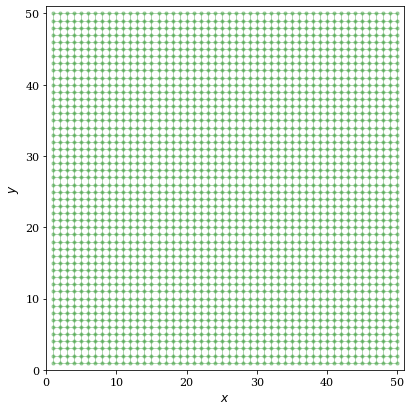

In [7]:
plot_graph(full_graph)

Create a graph with randomly removed edges

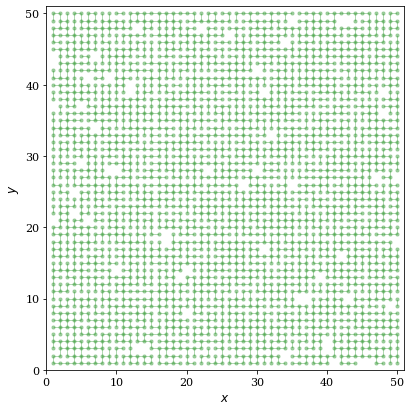

In [8]:
n_edges = 3000
rnd.shuffle(all_edges)
edges   = all_edges[:n_edges]
graph   = nx.Graph()
graph.add_edges_from(edges)
plot_graph(graph)

### Target state
Based on the image above, choose target state.

In [9]:
target_state = (25, 25)

### Model environment
The states of the environment, itself modeled by the class *Environment*, are modeled as tuples $(x, y)$ with different integer values for the attributes $x$ and $y$. An action, $a$, is a mapping $a: (x, y) \rightarrow (x^\prime, y^\prime)$ in which the attributes $x, x^\prime$ and $y, y^\prime$ differ, at most, by one unit. The environment class exports a few useful methods, such as *neighbors$(s)$* which returns, in a list, the nearest neighbor states connected to state $s$. Given the pair $(s, a)$, the environment returns the value of the immediate award $R(s, a)$ as well as the next state of the environment $s^\prime$. Note, since in this example, $R(s, a)$ depends on $s^*$, the environment needs to be made aware of the desired target state $s^*$.

In this example, the immediate reward function is rather simple

\begin{align}
R(s, a) & = \begin{cases}
                r, & \text{if } s^\prime = s^*, \textrm{ where } a: s \rightarrow s^\prime \\
                0  & \text{otherwise};
            \end{cases}
\end{align}
the agent gets an immediate reward if its action transitions the environment to the target state, otherwise the agent gets nothing.

In [10]:
class Environment:
    '''
 Help on class Environment:

 class Environment
  |  Environment(graph)
  |
  |  Model an environment whose states are modeled by tuples (x, y),
  |  where x and y are non-negative integers.
  |
  |  Parameters
  |  ----------
  |  graph         : graph defining the set of environment histories.
  |  rmax          : maximum immediate reward (default=1.0)
    '''
    def __init__(self, graph, rmax=1.0):
        
        self.graph  = graph  
        self.target = None  # target state
        self.state  = None  # current state
        self.rmax   = rmax  # maximum reward
        
    def __del__(self):
        pass
    
    def __len__(self):
        return self.number_of_states()
    
    def number_of_states(self):
        return len(self.graph)
    
    def number_of_actions(self):
        return len(self.graph.edges)
        
    def current_state(self):
        return self.state
    
    def target_state(self):
        return self.target
           
    def max_reward(self):
        return self.rmax
    
    def states(self):
        return list(self.graph)
         
    def actions(self):
        return list(self.graph.edges)
    
    def neighbors(self, state):
        if state in self.graph:
            return list(self.graph[state])
        else:
            return None
        
    def set_target_state(self, target_state):
        self.target = target_state
    
    # implement action a: state => next_state
    def step(self, state, action):
        self.state = state
        
        # make sure we have a valid (state, action) pair
        states = self.neighbors(state)
        if states == None:        return (state, 0)
        if action <  0:           return (state, 0)
        if action >= len(states): return (state, 0)
        
        # compute immediate reward
        r = self.rmax if states[action] == self.target else 0
        
        # transition to next state
        next_state = states[action]
        self.state = next_state
        
        return (next_state, r)

In [11]:
env = Environment(graph)

### Model $Q(s, a)$ function

Trained using: __Temporal Difference Update__,

\begin{align}
    Q(s, a) & \leftarrow (1 - \alpha) Q(s, a)  + \alpha [R(s, a) + \gamma \max_{a^\prime}Q(s^\prime, a^\prime)] .
\end{align}

In [12]:
class Qfunction:    
    def __init__(self, env, 
                 gamma=0.9, alpha=1.0, epsilon=1.0, depsilon=0.0):
        
        # cache inputs, including the environment
        self.env      = env             
        self.gamma    = gamma
        self.alpha    = alpha
        self.epsilon  = epsilon
        self.depsilon = depsilon
        self.p        = 1 - epsilon
        self.max_R    = env.max_reward()
        self.sum_Q    = 0.0
        self.max_Q    = 0.0
        
        # initialize scores and Q function
        self.reset()

    def __del__(self):
        pass
    
    def __call__(self, state, action):
        Q = self.Q
        if state not in Q:
            return -1
        if action < 0:
            return -2
        if action >= len(Q[state]):
            return -3
        return Q[state][action]
    
    def __str__(self):
        Q      = self.Q
        env    = self.env
        states = list(Q.keys())
        states.sort()
        
        s_str = ''
        for i, s in enumerate(states):
            qq = Q[s]
            nn = env.neighbors(s)
            
            x, y = s
            s_str += '%5d (%2d,%2d) =>' % (i,x,y)
            
            for n in nn: s_str += ' (%2d,%2d)' % n
            s_str += '\n%16s' % ''
            
            for q in qq: s_str += ' %6.3f ' % q
            s_str += '\n'
            
        return s_str[:-1]
    
    def reset(self):
        env = self.env
        # initialize scores
        self.scores = []
        # initialize Q function to zero 
        # forall pairs (s, a)
        self.Q = {} # Q values
        for state in env.states():
            self.Q[state] = [0]*len(env.neighbors(state))
            
    def update(self, state, action):
        gamma = self.gamma
        alpha = self.alpha
        Q     = self.Q
        env   = self.env
        
        # get next state and reward associated with
        # action a: state => next_state
        next_state, reward = env.step(state, action)
        
        # update Q value
        # note: if alpha = 0.0, the agent learns nothing.
        #       if alpha = 1.0, the agent relies solely on
        #       the current expected reward and not at all 
        #       on prior estimates of the expected reward.
        # gamma < 1 implies that future rewards are discounted
        # relative to immediate rewards and the discount increases
        # geometrically the more distant the future is from the
        # present.
        
        s = state
        a = action
        n = next_state
        
        # for state n, get the action k with the largest Q value
        k = np.argmax(Q[n])
        
        # update Q function
        Q_prev  = Q[s][a]
        
        Q[s][a] = (1 - alpha)*Q[s][a] + alpha*(reward + gamma*Q[n][k])

        Q_new   = Q[s][a]
        
        # update sum(Q)
        self.sum_Q -= Q_prev
        self.sum_Q += Q_new
        # update max(Q)
        if Q_new > self.max_Q: self.max_Q = Q_new
        
        # compute score
        score = self.max_R*self.sum_Q/self.max_Q if self.max_Q > 0 else 0

        return score
    
    def pick_state(self):
        Q = self.Q
        k = rnd.randint(len(Q))
        return list(Q.keys())[k]
    
    def pick_action(self, state):
        Q = self.Q
        if state not in Q: return None
        if len(Q[state]) == 0: return None
        
        # implement epsilon greedy policy:
        #   for the given state, pick with probability 
        #   p = 1 - epsilon the action with the largest Q value 
        #   else pick a random action.
        u = np.random.uniform()
        if u < self.p:
            # pick action with the largest Q value
            a = np.argmax(Q[state])
        else:
            # pick a random action
            a = rnd.randint(len(Q[state]))
        return a
        
    def train(self, target_state, 
              n_iterations=10001, 
              reset_training=False):
        # need to set target state since the immediate
        # reward function computed by the environment
        # depends on it.
        self.env.set_target_state(target_state)
        
        if reset_training:
            self.reset()
            
        for ii in range(n_iterations):
            
            # pick a state at random
            state  = self.pick_state()
            
            # pick action according to an 
            # epsilon-greedy policy
            action = self.pick_action(state)
            
            # update Q function
            score  = self.update(state, action)
            self.scores.append(score)
            
            # print score
            if ii % 1000 == 0:
                print('\r%5d\tscore: %10.2f' % (ii, score), end='')
            
    def set_Q(self, Q):
        self.Q = Q
        
    def get_Q(self):
        return self.Q
    
    def get_path(self, state):
        # use greedy policy: 
        # choose action with largest Q value.
        start = state
        path  = [start]
        
        Q     = self.Q
        env   = self.env
        target= env.target_state()
        max_it= 10 * len(Q)
        
        ii = 0
        while (state != target) and (ii < max_it):
            ii += 1
            # get action with highest Q for given state
            action = np.argmax(Q[state])
            
            # get the next state using optimal action
            next_state = env.neighbors(state)[action]
            
            # if the next_state is already in the current
            # path, then assume that the agent is lost!
            if next_state == None or next_state in set(path):
                path = []
                break
                    
            # continue building path
            path.append(next_state)
            state = next_state
        return path

### Now train $Q$!

In [13]:
Q = Qfunction(env)

In [14]:
n_iter = 200001
Q.train(target_state, n_iter)

500000	score:     577.23

In [15]:
def plot_scores(scores): 
    # create an empty figure
    fig = plt.figure(figsize=(8, 4))
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_ylim((0, 1.1*max(scores)))
    ax.set_xlim((0, len(scores)))
    
    ax.plot(scores, 'b')
    ax.set_xlabel('iterations', fontsize=16)
    ax.set_ylabel('score', fontsize=16)
    ax.grid(True, which="both", linestyle='-')

    plt.show()

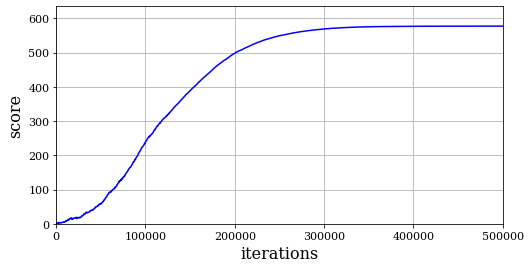

In [16]:
plot_scores(Q.scores)

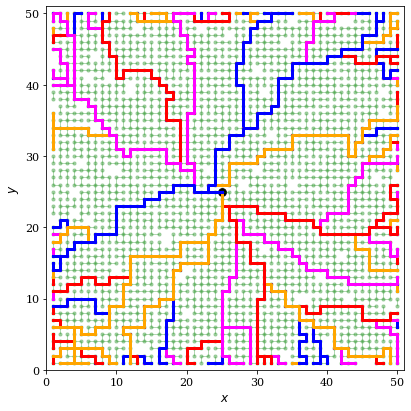

In [17]:
paths= []
for start in graph:
    if start == target_state: continue
        
    x, y = start
    boundary = (x==1) or (x==N) or (y==1) or (y==N)
    if not boundary: continue
        
    path = Q.get_path(start)
    if len(path) == 0: continue
    paths.append(path)
    
plot_graph(graph, 
           paths=paths,
           target=target_state,
           filename='04_maze.png')